Installing and Importing required Libraries

In [ ]:
#Discard the output of this cell
%%capture

#install the required libraries
!pip install pafy youtube-dl moviepy

In [ ]:
#import the required libraries
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Setting Numpy,Python and Tensorflow to get consistent results on every exection

In [ ]:
#Control the randomness and assigned to certain constants
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Download and Visualizing the Data with its label
###We are using UCF50-Action Recognition Dataset which is consisting of realistic videos taken from youtube which dufferentiates this data set from most of the other available action recognition data as they are not realistic and are staged by actors. The dataset includes,

#### 50 action categories
#### 25 groups of video per action category
#### 133 average videos per action cetegory
#### 199 average number of frames per video
#### 320 average frames width per video
#### 240 average frames height per video
#### 26 average frames per seconds per video


In [ ]:
#Discard the output  of this cell
%%capture
#Download the USF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

#Extract the Dataset
df=!unrar x UCF50.rar

# List files in the extracted directory
# !ls UCF50

# Read and display the head of a specific file in the dataset (replace 'filename' with the actual filename)
# import pandas as pd
# df = pd.read_csv('UCF50/WalkingWithDog.csv')
# df.head()

In [ ]:
#create a matplotlib figure and sprcify the size of the figure
plt.figure(figsize = (20, 20))

#Get the names of all classes/categories in UCF50
all_classes_names = os.listdir('UCF50')

#generate a list of 20 random values. The values will be between 0-50,
#where 50 is the total number of class in the dataset
random_range = random.sample(range (len(all_classes_names)), 20)

#Iterating through all  the generated random values.
for counter, random_index in enumerate(random_range, 1):

  #Retrieve a class name using the random index
  selected_class_name = all_classes_names[random_index]

  #Retrieve the list of all the video files present in the randomly selected class directory
  video_files_names_list = os.listdir(f'UCF50/{selected_class_name}')

  #Randomly select a video file from the list retrieved from the randomly selected class directory
  selected_video_file_name = random.choice(video_files_names_list)

  #Initialize a video capture object to read from the video file
  video_reader = cv2.VideoCapture(f'UCF50/{selected_class_name}/{selected_video_file_name}')

  #Read the first frame of the video file
  _, bgr_frame = video_reader.read()

  #Release the video capture object
  video_reader.release()

  #Convert the frame from BGR into RGB format
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

  #Write the class name on the video frame
  cv2.putText(rgb_frame, selected_class_name, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

  #Display the frame
  plt.subplot(5,4, counter);
  plt.imshow(rgb_frame);
  plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

Preprosess the Dataset


In [ ]:
#Specify the height and width to which each video frame will be resized in our dataset
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

#Specify the number of frames of a video that will be fed to the model as one sequence
SEQUENCE_LENGTH = 20

#Specify the directory containing the UCF50 dataset
DATASET_DIR = "UCF50"

#Specify the list containing the names of the classes used for training. Feel free to choose any set of classes
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

#Create a function to Extract, Resize and Normalize frames
####Here we create a function "frames_extraction()" that will create a list containing the resized and normalized frames of a video whose path is passed to it as an argument. The function will read the video file frame by frame, although not all frames are added to the list as we will only an evenly distributed sequence length of frames.

###**Args**:
###*video_path*:The path of the video in the disk, whose frames are to be extracted
###**Return**:
###*frames_list*:A list containing the resized and normalized frames of the video

In [ ]:
def frames_extraction(video_path):

  #Declare a list to store video frames
  frames_list = []

  #Read the video file using the VideoCapture object
  video_reader = cv2.VideoCapture(video_path)

  #Get the total number of frames in the video
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  #Calculate the interval after which frames will be added to the list
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

  #Iterate through the video frames
  for frame_counter in range(SEQUENCE_LENGTH):

    #set the current frame position of the video
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

    #Reading the frame from the video
    success, frame = video_reader.read()

    #check if video frame is not successfully read then break the loop
    if not success:
      break

    #Resize the frame to fixed height and width
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

    #Normalized the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
    normalized_frame = resized_frame/255

    #Appened the normalized frame into the frames list
    frames_list.append(normalized_frame)

  #Release the VideoCapture object
  video_reader.release()

  #Return the frames list
  return frames_list



Create a function for Dataset Creation

In [ ]:
def create_dataset():

  #Declared an empty list to store the features, labels and video file path values
  features = []
  labels = []
  video_files_paths = []

  #Iterating through all the classes mentioned in the classes list
  for class_index, class_name in enumerate(CLASSES_LIST):

    #Display the name of the class whose data is being extracted
    print(f'Extracting Data of Class: {class_name}')

    #Get the list of video files present in the specific class name directory
    files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

    #Iterate through all the files present in the files list
    for file_name in files_list:

      #Get the complete video path
      video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

      #Extract the frames of the video file
      frames = frames_extraction(video_file_path)

      #Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above
      #So ignore the vides having frames less than the SEQUENCE_LENGTH
      if len(frames) == SEQUENCE_LENGTH:

        #Append the data to their repective lists
        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)

  #Converting the list to numpy arrays
  features = np.asarray(features)
  labels = np.array(labels)

  #Return the frames, class index, and video file path
  return features, labels, video_files_paths


Utilizing above created "create_dataset()" to extract the dataset of the selected classes and create the required dataset

In [ ]:
#create the dataset
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace


Converting labels(class indexes) into one-hot encoded vctors

In [ ]:
#Using Kera's to_categorial method to convert label: into one-hot-encoded vectores
one_hot_encoded_labels = to_categorical(labels)

#Split the data into Train and Test set
##We have created required features (a NumPy array containing all the extracted frames of the videos) and one_hot_encoded_labels (a NumPy array containing all class labels in one hot encoded format). Then before spliting dataset is shuffled in order to avoid any bias and get splits representing the overall distribution of data.

In [ ]:
#split the data into Train (75%) and Test (25%)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.25, shuffle=True, random_state=seed_constant)

#Implement the ConvLSTM Approach
####A ConvLSTM cell is a variant of an LSTM network that contains convolutions operations in the network. It is an LSTM with convolution embedded in the architecture, which makes it capable of identifying spatial features of the data while keeping into account the temporal relation.

##Construct the model
###To construct the model we used Keras ConvLSTM2D recurrent layers. The ConvLSTM2D layer also takes in the number of filters and kernal size required for applying the convolutional operations.The output of the layers is flattened in the end and is fed to the  Dense layer with softmax activation whhich outputs the probaability of each action category.
###Also we used the MaxPooling3D layers to reduce the dimensions of the  frames and avoid unnecessary computations and **Dropout** layers to prevent **overfitting** the model on the data. The architecture is a simple one and has a small number of trainable parameters. This because we are only dealing with a small subset of the dataset that does not require a larg-scale model.

In [ ]:
def create_convlstm_model():

  #we will use a sequential model for model construction
  model = Sequential()

  #Define the model architecture

  model.add(ConvLSTM2D(filters = 4,kernel_size = (3,3), activation = 'tanh', data_format = "channels_last",
                      recurrent_dropout = 0.2, return_sequences = True, input_shape = (SEQUENCE_LENGTH,IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

  model.add(MaxPooling3D(pool_size = (1,2,2), padding = 'same', data_format = 'channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 8,kernel_size = (3,3), activation = 'tanh', data_format = "channels_last",
                      recurrent_dropout = 0.2, return_sequences = True))

  model.add(MaxPooling3D(pool_size = (1,2,2), padding = 'same', data_format = 'channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 14,kernel_size = (3,3), activation = 'tanh', data_format = "channels_last",
                      recurrent_dropout = 0.2, return_sequences = True))

  model.add(MaxPooling3D(pool_size = (1,2,2), padding = 'same', data_format = 'channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 16,kernel_size = (3,3), activation = 'tanh', data_format = "channels_last",
                      recurrent_dropout = 0.2, return_sequences = True))

  model.add(MaxPooling3D(pool_size = (1,2,2), padding = 'same', data_format = 'channels_last'))

  model.add(Flatten())
  model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

  #Display the models summary
  model.summary()

  #Return the constructed convlstm model
  return model



Constructing required convlstm model utilizing function "create_convlstm_model()"




In [ ]:
#Construct the required convlstm model
convlstm_model = create_convlstm_model()

#Display the success message
print("The model created successfully!")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_5 (ConvLSTM2D)  (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d_5 (MaxPoolin  (None, 20, 31, 31, 4)     0         
 g3D)                                                            
                                                                 
 time_distributed_3 (TimeDi  (None, 20, 31, 31, 4)     0         
 stributed)                                                      
                                                                 
 conv_lstm2d_6 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_6 (MaxPoolin  (None, 20, 15, 15, 8)     0         
 g3D)                                                            
                                                      

#Check Model's Structure
#### Here we use the plot_model() function to check the structure of the constructed model, this is helpful while constructing a complex network and marketing that the network is created correctly

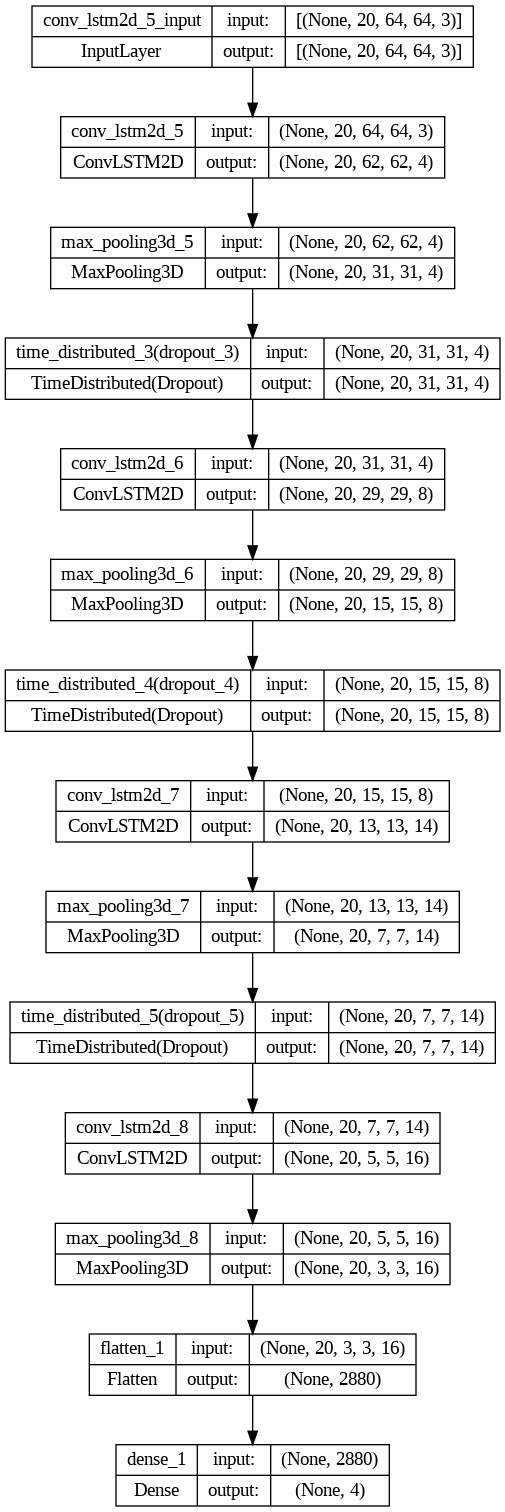

In [ ]:
#Plot the structure of the constructed model
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

#Compile and train the model
####Next we add an early stopping call back to preb=vent **Overfitting** and start the training after compiling the model

In [ ]:
#Creating an instance of early stopping callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

#Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

#Start training the model
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])


Epoch 1/50
73/73 [==============================] - 138s 2s/step - loss: 1.3545 - accuracy: 0.3253 - val_loss: 1.2983 - val_accuracy: 0.3151
Epoch 2/50
73/73 [==============================] - 132s 2s/step - loss: 1.2606 - accuracy: 0.4144 - val_loss: 1.2098 - val_accuracy: 0.4521
Epoch 3/50
73/73 [==============================] - 139s 2s/step - loss: 1.1261 - accuracy: 0.5685 - val_loss: 0.9240 - val_accuracy: 0.6301
Epoch 4/50
73/73 [==============================] - 157s 2s/step - loss: 0.9033 - accuracy: 0.6507 - val_loss: 0.7246 - val_accuracy: 0.7260
Epoch 5/50
73/73 [==============================] - 159s 2s/step - loss: 0.7430 - accuracy: 0.6986 - val_loss: 0.6431 - val_accuracy: 0.7123
Epoch 6/50
73/73 [==============================] - 146s 2s/step - loss: 0.5947 - accuracy: 0.7603 - val_loss: 0.5826 - val_accuracy: 0.7397
Epoch 7/50
73/73 [==============================] - 121s 2s/step - loss: 0.4413 - accuracy: 0.8425 - val_loss: 0.5821 - val_accuracy: 0.7671
Epoch 8/50
73

Evaluate the model on the testing set

In [ ]:
#Evaluate the trained model
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

4/4 [==============================] - 14s 3s/step - loss: 0.6639 - accuracy: 0.8033


#Save the Model
####In order to avoid the model training from scratch every time, we save it.

In [ ]:
#Get the loss and accuracy from model_evaluation_history
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

#Define the string date format
#Get the current date and time in a DateTime object
#Convert the DateTime object to string according to the style mentioned in date_time_format string
date_time_format = '%Y_%m_%d_%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

#Define a useful name for our model to make it easy for us while navigating through multiple saved models
model_file_name = f'convlstm_model__Date_Time_{current_date_time_string}__Loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'

#Save model
convlstm_model.save(model_file_name)

  saving_api.save_model(



#Plot Model's Loss & Accuracy Curves
####Creating a function plot_metric() to visualize the training and validation metrics.

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

  #Get metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  #Construct a range object which will be used as x_axis {horizontal plane} of the graph
  epochs = range(len(metric_value_1))

  #Plot the Graph
  plt.plot(epochs,metric_value_1,'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

  #Add title to plot
  plt.title(str(plot_name))

  #Add legend to the plot
  plt.legend()


Utilizing the function "plot_metric()" to visualize and understand the metrics

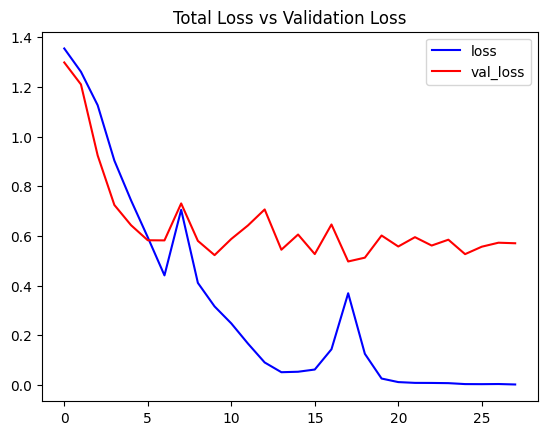

In [ ]:
#Visualizing the training and validation loss metrices
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

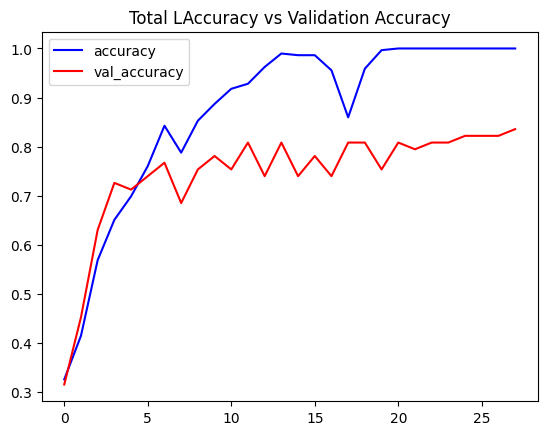

In [ ]:
#Visualizing the training and validation accuracy metrices
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total LAccuracy vs Total Validation Accuracy')

#Implement the LRCN Approach (Long-term Recurrent Convolutional Network) which combines the CNN and LSTM layers in a single model.
#### Here we implement the LRCN Approach by combining Convolution and LSTM layers in a single model.Another similar approach can be to use a CNN model and LSTM model trained seperately
##### The CNN model can be used to extract spatial features from the frames in the vodeo, and for this purpose, a pre-trained model can be used, that can be fine-tuned for the problem and then LSTM model can be use the features extracted by CNN to predict the action being performed in the video.
##### Here we also used the **TimeDistributed** Wrapper layer which allows apply the same layer to every frame of the video independently.It makes a layer caple of taking input of shape (no_of_frames, width,height,num_of_channnels). If originally the layer's input shape was (width,height,num_of_channels) which is very beneficial as it allows to input the whole video into the model in single shot.

#Construct the Model

####To implement the LRCN architecture we use the time-distributed **Conv2D** layers which will be followed by **MaxPooling2D** and Dropout layers. The feature extracted from the **Conv2D** layers will be then flattened using the **Flatten**layer and will be fed to a LSTM layer. The dense layer with softmax activation will then use the output from the LSTM layer to predict the action being performed

In [ ]:
def create_LRCN_model():
  #We will use a Sequential model for the model construction
  model = Sequential()

  #Define the model architecture
  model.add(TimeDistributed(Conv2D(16, (3,3),  padding = 'same', activation = 'relu'),
                     input_shape = (SEQUENCE_LENGTH,IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

  model.add(TimeDistributed(MaxPooling2D((4,4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(32, (3,3),  padding = 'same', activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((4,4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64, (3,3),  padding = 'same', activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64, (3,3),  padding = 'same', activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(32))

  model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

  #display the models summary
  model.summary()

  #Return the constructed LRCN model
  return model

Construct the required LRCN model utilizing the function "create_LRCN_model()"

In [ ]:
#Construct the required LRCN model
LRCN_model = create_LRCN_model()

#Display the success message
print("Model Created Successfully!")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDi  (None, 20, 64, 64, 16)    448       
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, 20, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_8 (TimeDi  (None, 20, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_9 (TimeDi  (None, 20, 16, 16, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, 20, 4, 4, 32)     

#Check Model's Structure
####Check the structure of the constructed LRCN model using"plot_model()" function

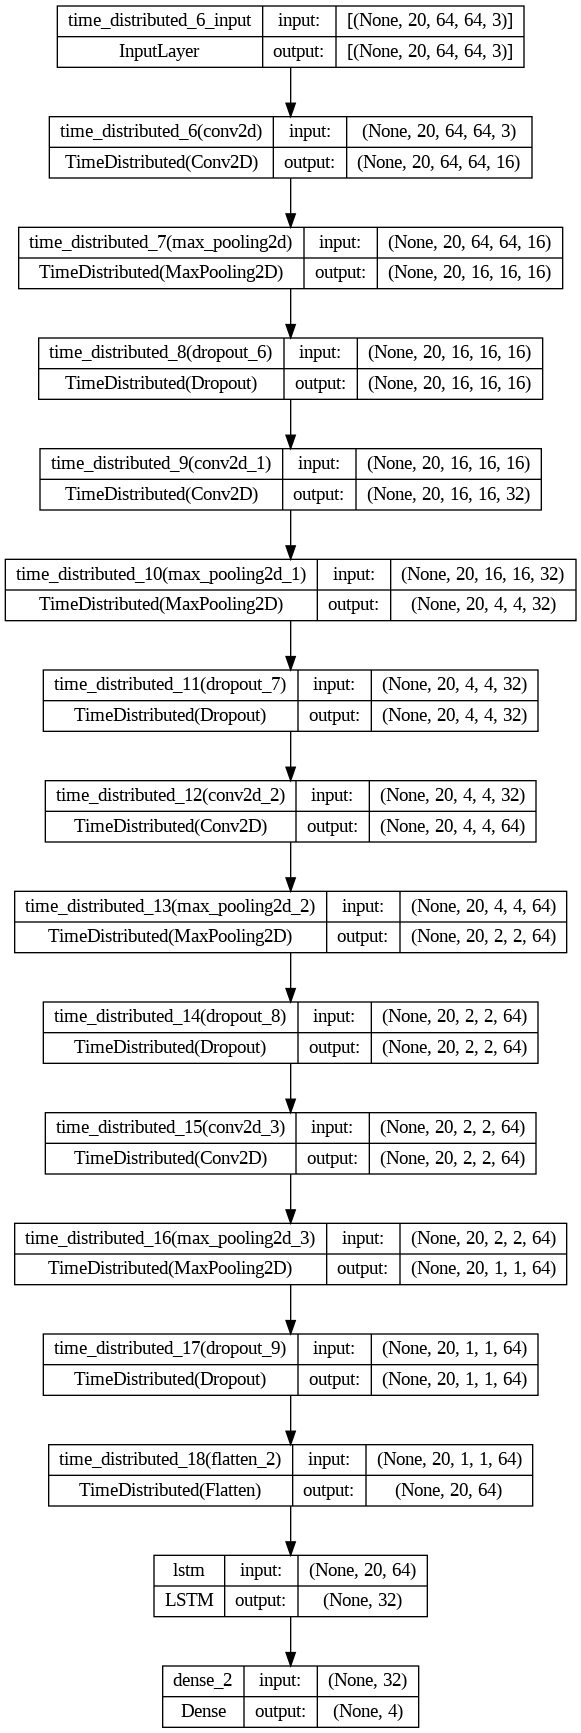

In [ ]:
#Plot the structure of the constructed model
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names= True)

#Compile and Train the model

In [ ]:
#Creating an instance of early stopping callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

#Compile the model and specify loss function, optimizer and metrics values to the model
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

#Start training the model
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])


Epoch 1/70
73/73 [==============================] - 19s 228ms/step - loss: 1.3979 - accuracy: 0.2774 - val_loss: 1.3618 - val_accuracy: 0.3699
Epoch 2/70
73/73 [==============================] - 14s 189ms/step - loss: 1.3653 - accuracy: 0.3151 - val_loss: 1.3762 - val_accuracy: 0.1918
Epoch 3/70
73/73 [==============================] - 12s 162ms/step - loss: 1.3140 - accuracy: 0.3733 - val_loss: 1.2514 - val_accuracy: 0.4521
Epoch 4/70
73/73 [==============================] - 14s 197ms/step - loss: 1.2591 - accuracy: 0.4007 - val_loss: 1.3577 - val_accuracy: 0.2603
Epoch 5/70
73/73 [==============================] - 13s 183ms/step - loss: 1.1093 - accuracy: 0.5171 - val_loss: 0.9524 - val_accuracy: 0.6301
Epoch 6/70
73/73 [==============================] - 13s 179ms/step - loss: 0.8993 - accuracy: 0.6027 - val_loss: 0.7123 - val_accuracy: 0.7397
Epoch 7/70
73/73 [==============================] - 13s 175ms/step - loss: 0.8644 - accuracy: 0.6336 - val_loss: 0.6911 - val_accuracy: 0.7671

Evaluating the Trained Model

In [ ]:
#Evaluate the trained model
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

4/4 [==============================] - 2s 388ms/step - loss: 0.3765 - accuracy: 0.8607


#Save the Model

In [ ]:
#Get the loss and accuracy from model_evaluation_history
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

#Define the string date format
#Get the current date and time in a DateTime object
#Convert the DateTime object to string according to the style mentioned in date_time_format string
date_time_format = '%Y_%m_%d_%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

#Define a useful name for our model to make it easy for us while navigating through multiple saved models
model_file_name = f'LRCN_model__Date_Time_{current_date_time_string}__Loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'

#Save model
LRCN_model.save(model_file_name)

#Plot the Model's Loss and Accuracy Curves

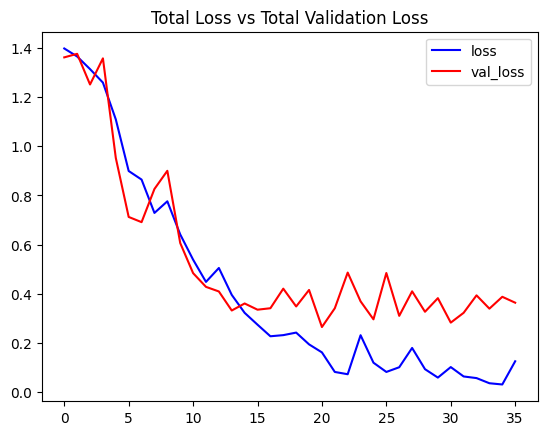

In [ ]:
#Visualizing the training and validation loss metrices
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

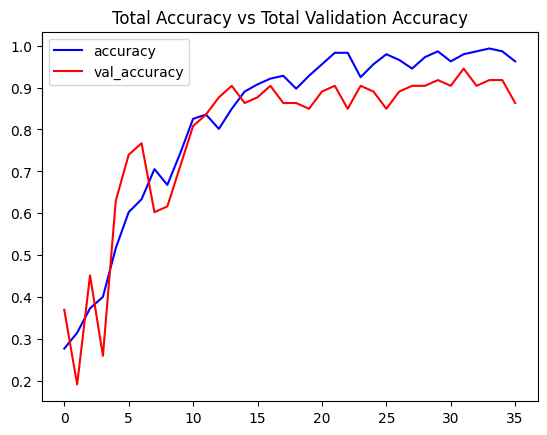

In [ ]:
#Visualizing the training and validation accuracy metrices
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

#Test the Best Performing Model on Youtube videos
##### When consider the above results we can identify that LRCN model performed well for a small number of classes. So here we use the LRCN model too test on some youtube videos

##Create a function to Download YouTube Videos
##### The function "download_youtube_videos()" is created todownload youtube videos  using pafy library that only requires a URL to a video to download it along with its associated metadata such as the title of the video

In [ ]:
def download_youtube_videos(youtube_video_url, output_directory):

  #Create a video object ehich contains useful information about the video
  video = pafy.new(youtube_video_url)

  #Retrieve the title of the video
  title = video.title

  #Get the best available quality object for the video
  video_best = video.getbest()

  #Construct the output file path
  output_file_path = f'{output_directory}/{title}.mp4'

  #Download the youtube video at the best avaolable quality and store it to the constructed path
  video_best.download(filepath = output_file_path, quiet = True)

  #Return the video title
  return title

##Download a Test Video

[youtube] 8u0qjmHIOcE: Downloading webpage


ERROR: Unable to extract uploader id; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


Error downloading video: ERROR: Unable to extract uploader id; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.
Failed to download video.


In [ ]:

#Make the output directory if it does not exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

#Download a youtube video
video_title = download_youtube_videos('https://www.youtube.com/watch?v=8u0qjmHIOcE', test_videos_directory )
#https://www.youtube.com/watch?v=8u0qjmHIOcE

#Get the Youtube Video's path we just downloaded
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'



ERROR: Unable to extract uploader id; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


OSError: ERROR: Unable to extract uploader id; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.

##Create a function to perform Action Recognition on Videos
#####This function will simply read a video by frame by frame from the path passed in as an argument and will perform action recognition on video and save the results

In [80]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):

  #Initialize the VideoCapture object to read from the video file
  video_reader = cv2.VideoCapture(video_file_path)

  #Get the width and height of the video
  original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
  original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

  #Initialize the VideoWriter Object to store the output video in the disk
  video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M','P','4','V'),
                                 video_reader.get(cv2.CAP_PROP_FPS),(original_video_width, original_video_height))

  #Declare a queue to store video frames
  frames_queue = deque(maxlen = SEQUENCE_LENGTH)

  #Initialize a variable to store th predicted action being performed in the video
  predicted_class_name = ''

  #Iterate until the video is accessed successfully
  while video_reader.isOpened():

    #Read the frame
    ok, frame = video_reader.read()

    #Check if frame is not read properly then break the loop
    if not ok:
      break

    #Resize the frame to fixed Dimensions
    resized_frame = cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))

    #Normalize the resized frame by dividing it with 255. So that each pixel value then lies between 0 and 1
    normalized_frame = resized_frame/255

    #Appending the pre-processed frame into the frames list
    frames_queue.append(normalized_frame)

    #Check if the number of frames in the queue are equal to the fixed sequence length
    if len(frames_queue) == SEQUENCE_LENGTH:
      #Pass the normalized frames to the model and get the predicted probabilities
      predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

      #Get the index of class with highest probability
      predicted_label = np.argmax(predicted_labels_probabilities)

      #Get the class name using the retrieved index
      predicted_class_name = CLASSES_LIST[predicted_label]

    #Write predicted class name on top of the frame
    cv2.putText(frame, predicted_class_name, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    #Write the frame into the disk using the VideoWriter Object
    video_writer.write(frame)

  #Release the VideoCapture and VideoWriter objects
  video_reader.release()
  video_writer.release()




##Perform Action Recognition on the Test Video

In [81]:
#Construct the output video path
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

#Perform Action Recognition on the Test Video
predict_on_video(input_video_file_path , output_video_file_path, SEQUENCE_LENGTH)

#Display the output video
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300, None)). ipython_display()



NameError: name 'input_video_file_path' is not defined

##Create a function to perform a Single Prediction on Videos
##### This is about create a function that will perform a single prediction for the complete videos. We extract evenly distributed N (SEQUENCE_LENGTH)frames from the entire video and pass them to the LRCN model. This approach is useful when we working with videos containing only one activity as it saves unnecessary computations and time

In [ ]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):

  #Initialize the VideoCapture object to read from the video file
  video_reader = cv2.VideoCapture(video_file_path)

  #Get the width and height of the video
  original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
  original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

  #Declare a list to store video frames we are extracting
  frames_list = []

  #Initialize a variable to store the predicted action being performed in the video
  predicted_class_name = ''

  #Get the number of frames in the video
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  #Calculate the interval after which frames will be added to the list
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

  #Iterating the number of times equal to the fixed length of sequence
  for frame_counter in range(SEQUENCE_LENGTH):
    #Set the current frame position of the video
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

    #Read a frame
    success, frame = video_reader.read()

    #Check if frame is not read properly then break the loop
    if not success:
      break

    #Resize the frame to fixed Dimensions
    resized_frame = cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))

    #Normalize the resized frame by dividing it with 255. So that each pixel value then lies between 0 and 1
    normalized_frame = resized_frame/255

    #Appending the pre-processed frame into the frames list
    frames_list.append(normalized_frame)

  #Pass the pre=processed frames to the model and get the predicted probabilities
  predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_list, axis = 0))[0]

  #Get the index of class with highest probability
  predicted_label = np.argmax(predicted_labels_probabilities)

  #Get the class name using the retrieved index
  predicted_class_name = CLASSES_LIST[predicted_label]

  #Display the predicted action along with the prediction confidence
  print(f'Action Predicted: {predicted_class_name}\nconfidence: {predicted_labels_probabilities[predicted_label]}')

  #Release the VideoCapture objects
  video_reader.release()


##Perform Single Prediction on a Test Video

In [ ]:
#Download the youtube video
video_title = download_youtube_videos('https://www.youtube.com/watch?v=ayI-e3cJM-0', test_videos_directory )

#Construct the input video path
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

#Perform Single Prediction on the Test Video
predict_single_action(input_video_file_path, SEQUENCE_LENGTH)

#Display the output video
VideoFileClip(input_video_file_path, audio=False, target_resolution=(300, None)). ipython_display()

ERROR: Unable to extract uploader id; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


OSError: ERROR: Unable to extract uploader id; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.